In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 18.8MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 3.2MB 44.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=73ad06a3716abeed314e331f084f6ebc7906c22e70d6f1f008ef941f0f4703ea
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

from transformers import AutoConfig, AutoTokenizer, TFAutoModel



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
config = AutoConfig.from_pretrained('nlpaueb/legal-bert-base-uncased')

In [ ]:
config

BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/SEBI /Adjudication Orders Annotations JSON/Model Data CSV/train_5.csv")
valid = pd.read_csv("/content/drive/MyDrive/SEBI /Adjudication Orders Annotations JSON/Model Data CSV/valid_5.csv")
test = pd.read_csv("/content/drive/MyDrive/SEBI /Adjudication Orders Annotations JSON/Model Data CSV/test_5.csv")

In [ ]:
print(train.shape)
train = train.drop(['Unnamed: 0', 'Sentence ID'],axis = 1)
print(train.shape)
train.head()

(1608, 4)
(1608, 2)


,Label,Sentence
0,material fact,Securities and Exchange Board of India (herein...
1,material fact,The Investigating Authority observed that M s ...
2,material fact,"Out of the said shares, the Noticee on Decembe..."
3,material fact,"Further, the Noticee sold the remaining 1,60,5..."
4,material fact,"The Noticee on December 11, 2009 transferred s..."


In [ ]:
train = train[['Sentence','Label']]

In [ ]:
train.head()

,Sentence,Label
0,Securities and Exchange Board of India (herein...,material fact
1,The Investigating Authority observed that M s ...,material fact
2,"Out of the said shares, the Noticee on Decembe...",material fact
3,"Further, the Noticee sold the remaining 1,60,5...",material fact
4,"The Noticee on December 11, 2009 transferred s...",material fact


In [ ]:
test = test.drop(['Unnamed: 0', 'Sentence ID'],axis = 1)
test = test[['Sentence','Label']]

In [ ]:
test.head()
len(test)

471

In [ ]:
train.head()


,Sentence,Label
0,Securities and Exchange Board of India (herein...,material fact
1,The Investigating Authority observed that M s ...,material fact
2,"Out of the said shares, the Noticee on Decembe...",material fact
3,"Further, the Noticee sold the remaining 1,60,5...",material fact
4,"The Noticee on December 11, 2009 transferred s...",material fact


In [ ]:
max_seq_len = 128
input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
bert_model = TFAutoModel.from_pretrained(pretrained_model_name_or_path='nlpaueb/legal-bert-base-uncased', config=config, from_pt=True)
bert_output = bert_model(input_ids)

bert_output_cls = bert_output.pooler_output


cls_out = keras.layers.Dropout(0.5)(bert_output_cls)
logits = keras.layers.Dense(units=10, activation="softmax")(cls_out)

model = keras.Model(inputs=input_ids, outputs=logits)
model.build(input_shape=(None, max_seq_len))



                                                           

In [ ]:
#preprocessing 
class Classifier:
  DATA_COLUMN = "Sentence"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[Classifier.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[Classifier.DATA_COLUMN], row[Classifier.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:

classes = train.Label.unique().tolist()
print(classes)

['material fact', 'violation', 'procedural fact', 'allegation', 'issues framed', 'statutory fact', 'defendant claim', 'subjective observation', 'related fact', 'penalty']


In [ ]:
data = Classifier(train, test, tokenizer, classes, max_seq_len=128)


1608it [00:00, 2101.49it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
471it [00:00, 2186.74it/s]

max seq_len 306


In [ ]:
print(data.test_x.shape)
print(data.test_y.shape) 
print(data.train_x.shape)
print(data.train_y.shape)



(471, 128)
(471,)
(1608, 128)
(1608,)


In [ ]:
data.train_x[0]


array([  101,   100, 14109,  1019,   117,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [ ]:
data.train_x[2]


array([ 101, 1683,  210,  446,  223,  222,  879,  117,  102,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 350)]             0         
_________________________________________________________________
tf_bert_model_13 (TFBertMode TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
dropout_710 (Dropout)        (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7690      
Total params: 109,489,930
Trainable params: 109,489,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=10,
)

Epoch 1/10
91/91 [==============================] - 54s 494ms/step - loss: 2.3218 - acc: 0.2043 - val_loss: 2.2821 - val_acc: 0.2298
Epoch 2/10
91/91 [==============================] - 43s 467ms/step - loss: 1.7551 - acc: 0.3952 - val_loss: 1.7980 - val_acc: 0.3478
Epoch 3/10
91/91 [==============================] - 43s 472ms/step - loss: 1.3460 - acc: 0.5108 - val_loss: 1.4697 - val_acc: 0.4783
Epoch 4/10
91/91 [==============================] - 43s 469ms/step - loss: 1.0294 - acc: 0.6362 - val_loss: 1.2538 - val_acc: 0.6087
Epoch 5/10
91/91 [==============================] - 43s 472ms/step - loss: 0.8580 - acc: 0.7147 - val_loss: 1.0497 - val_acc: 0.6646
Epoch 6/10
91/91 [==============================] - 43s 472ms/step - loss: 0.6946 - acc: 0.7689 - val_loss: 0.9702 - val_acc: 0.6646
Epoch 7/10
91/91 [==============================] - 43s 470ms/step - loss: 0.6000 - acc: 0.7909 - val_loss: 1.0191 - val_acc: 0.6335
Epoch 8/10
91/91 [==============================] - 43s 471ms/step - 

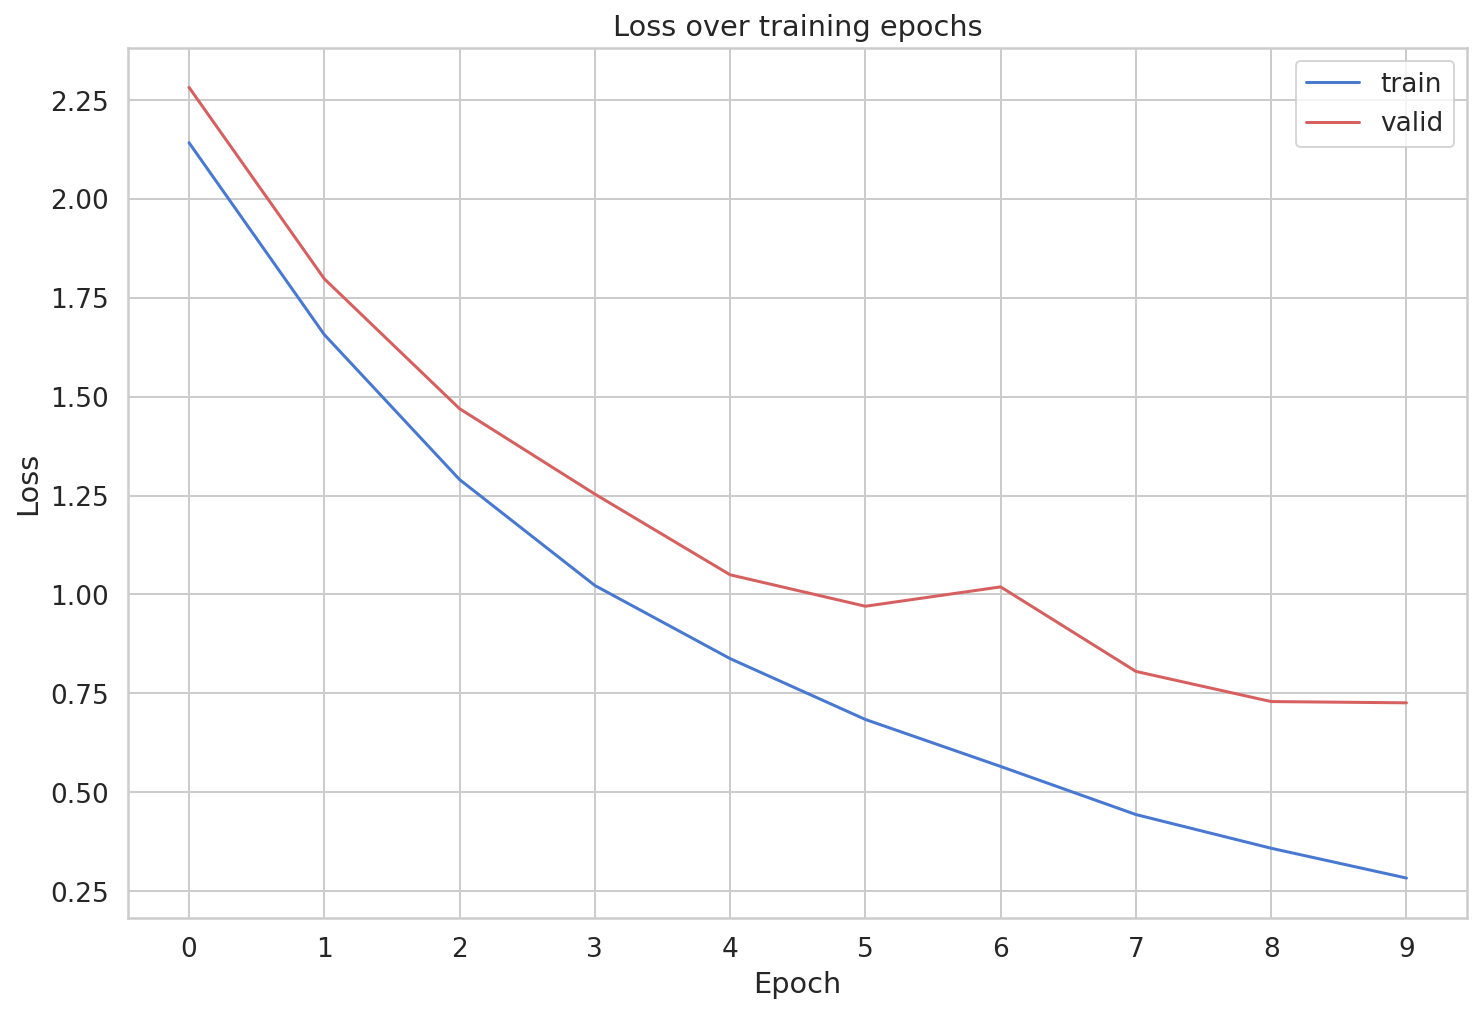

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'],'b')
ax.plot(history.history['val_loss'],'r')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Loss over training epochs')
plt.show();

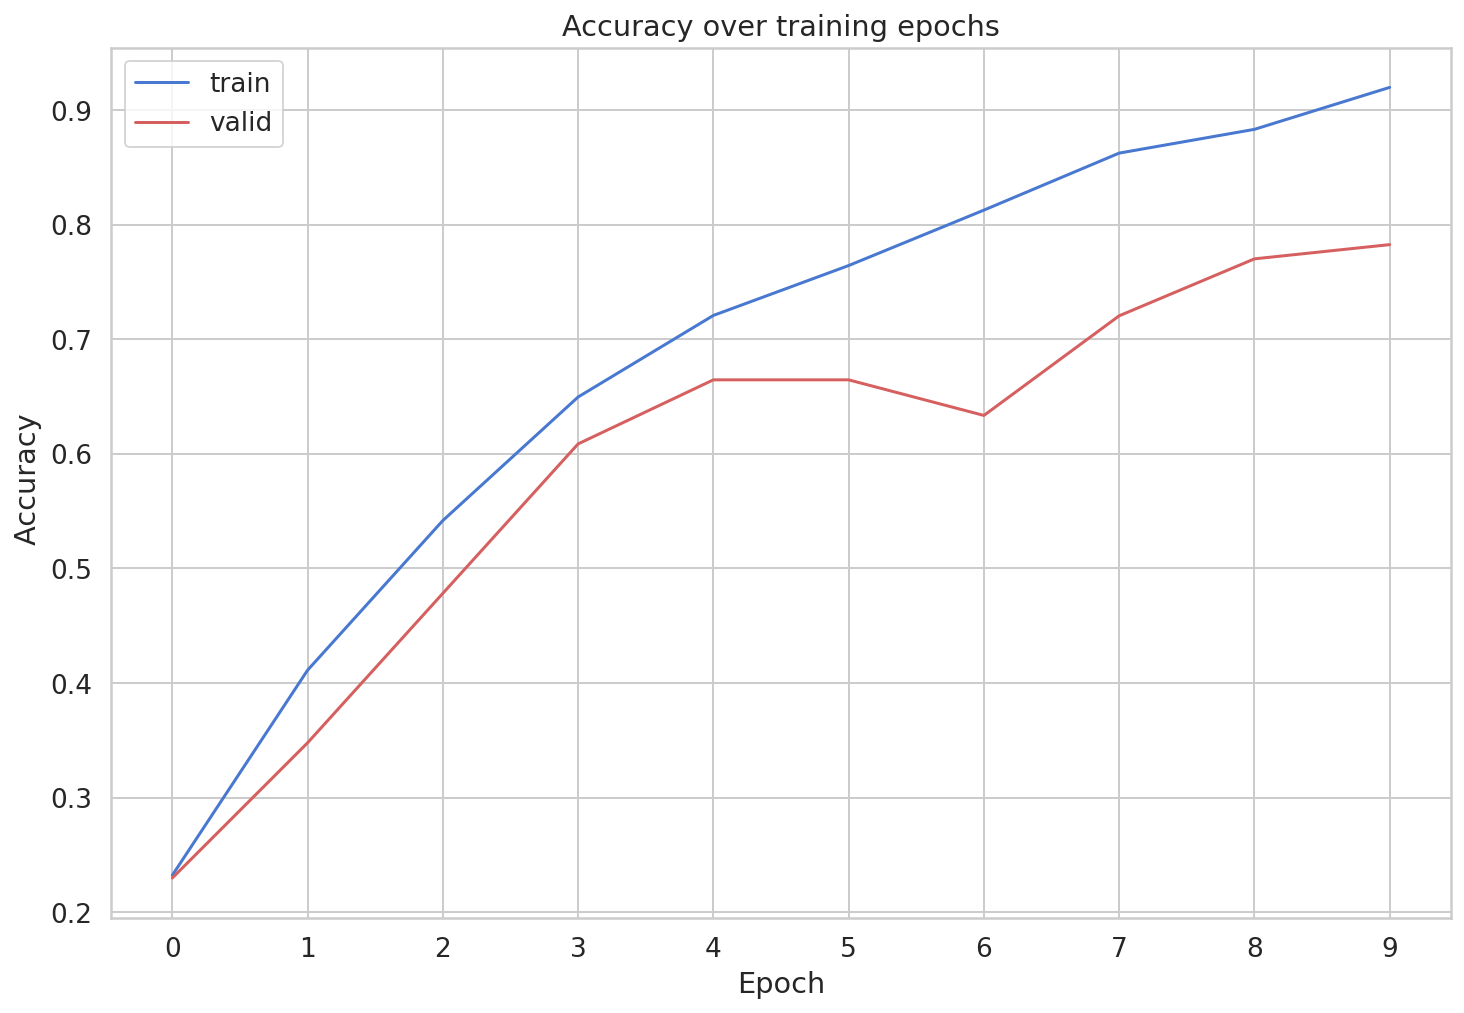

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'],'b')
ax.plot(history.history['val_acc'],'r')
plt.ylabel(' Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

15/15 [==============================] - 4s 256ms/step - loss: 0.9880 - acc: 0.7091
train acc 0.9533582329750061
test acc 0.7091295123100281


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
y_pred

array([2, 6, 6, 7, 4, 6, 4, 6, 7, 2, 8, 8, 0, 4, 2, 3, 7, 2, 0, 6, 7, 8,
       0, 6, 8, 2, 4, 4, 2, 6, 6, 0, 6, 2, 2, 7, 7, 6, 6, 7, 0, 8, 0, 0,
       7, 8, 7, 5, 2, 6, 8, 6, 0, 0, 6, 6, 4, 6, 0, 6, 6, 2, 2, 4, 6, 6,
       0, 0, 8, 0, 8, 0, 0, 2, 0, 2, 7, 7, 0, 6, 4, 0, 7, 1, 0, 6, 4, 0,
       6, 0, 6, 2, 0, 4, 0, 6, 6, 2, 6, 2, 7, 0, 2, 4, 0, 0, 0, 0, 0, 7,
       6, 7, 6, 5, 2, 2, 4, 2, 7, 6, 7, 2, 0, 4, 0, 0, 9, 0, 0, 4, 2, 7,
       8, 8, 0, 7, 6, 2, 0, 6, 0, 6, 6, 0, 7, 0, 6, 1, 6, 0, 0, 0, 0, 0,
       6, 7, 4, 0, 2, 2, 7, 6, 4, 0, 0, 6, 2, 8, 0, 8, 3, 0, 0, 2, 0, 2,
       2, 0, 0, 0, 2, 6, 2, 6, 7, 7, 0, 4, 6, 0, 6, 5, 6, 2, 2, 7, 0, 8,
       6, 0, 0, 6, 7, 0, 6, 0, 0, 6, 3, 2, 0, 2, 0, 7, 0, 6, 7, 8, 0, 2,
       2, 2, 2, 6, 2, 0, 0, 5, 0, 0, 2, 7, 5, 6, 0, 7, 0, 0, 0, 8, 8, 0,
       5, 0, 2, 2, 2, 7, 2, 2, 9, 0, 7, 8, 8, 6, 6, 6, 0, 0, 2, 2, 0, 6,
       0, 6, 0, 0, 7, 0, 6, 0, 0, 7, 7, 2, 0, 7, 2, 2, 8, 7, 6, 6, 2, 0,
       0, 2, 0, 0, 0, 0, 7, 0, 0, 7, 7, 7, 7, 7, 6,

In [ ]:
print(classification_report(data.test_y,y_pred, target_names=classes))


                        precision    recall  f1-score   support

         material fact       0.65      0.75      0.70       117
             violation       0.67      0.25      0.36         8
       procedural fact       0.83      0.91      0.87        69
            allegation       0.91      0.53      0.67        19
         issues framed       0.90      0.90      0.90        21
        statutory fact       0.89      0.79      0.84        39
       defendant claim       0.68      0.59      0.63       114
subjective observation       0.71      0.73      0.72        56
          related fact       0.29      0.42      0.34        19
               penalty       1.00      0.56      0.71         9

              accuracy                           0.71       471
             macro avg       0.75      0.64      0.67       471
          weighted avg       0.72      0.71      0.71       471

